In [1]:
import sys
sys.path.append('../../')

In [1]:
# import this to use Intel optimized sklearn if available
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from obelix_ml_pipeline.predictions_on_unseen_substrate_filtered import predict_out_of_sample_substrate
from obelix_ml_pipeline.representation_variables import AVAILABLE_LIGAND_REPRESENTATION_TYPES, AVAILABLE_SUBSTRATE_REPRESENTATION_TYPES
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [3]:
import os
path_to_figure_folder = os.path.join(os.getcwd(), 'figures/predictions_on_unseen_substrate_filtered')
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 16


# Objective 1a: Predictions on unseen substrate without ligands that are active/inactive across all substrates (only for classification)

For a complete new substrate, the model gives the performance of 192 ligands with an accuracy as high as possible
1A Methodology:
Classification on conversion with a dynamic threshold

*   Train on SM1, SM2 (SM7, SM8), predict SM3
*   Train on SM2, SM3 (SM7, SM8), predict SM1
*   Train on SM1, SM3 (SM7, SM8), predict SM2

## Example application of pipeline

Training and testing classifier
Test size in training (based on K-fold): 0.2
Mean test performance: 0.59 +/- 0.16
Best model performance: 1.00
Best model parameters: {'bootstrap': False, 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test set performance balanced_accuracy:  0.8330485304169515
Test set confusion matrix:  [[ 30   8]
 [ 19 135]]


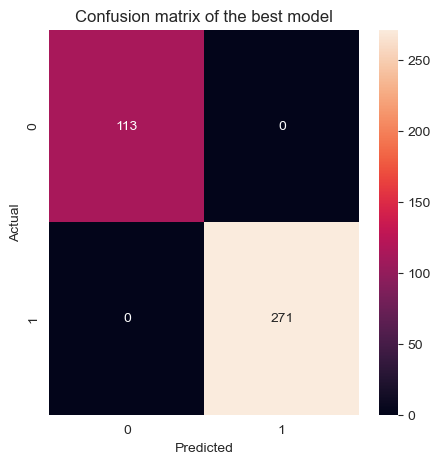

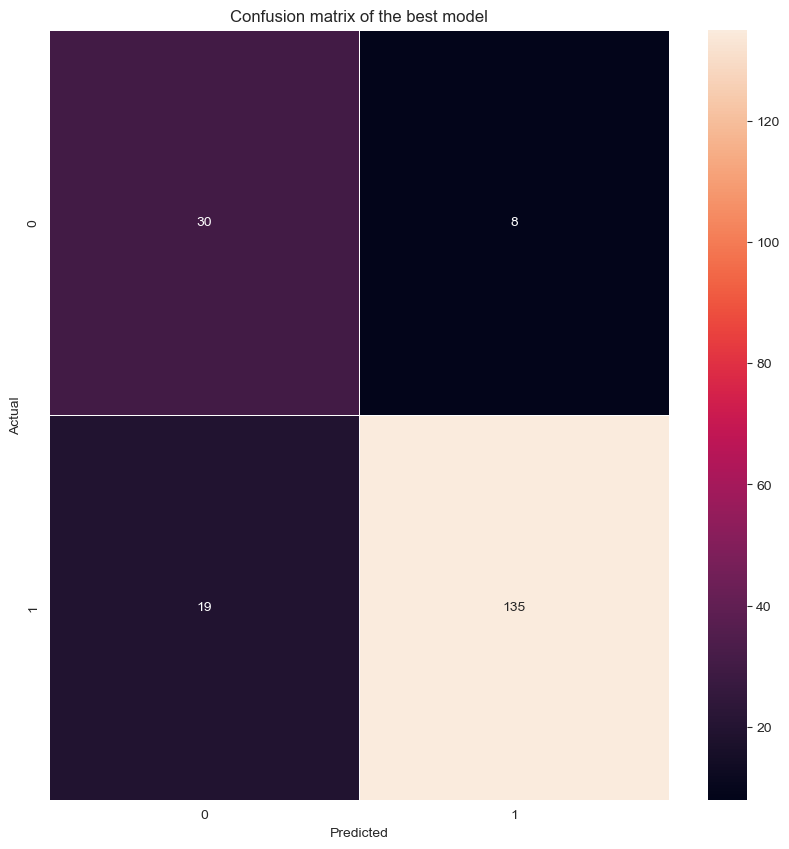

In [13]:
# try classifier with loaded representations
selected_ligand_representations = ['dft_nbd_model']
selected_substrate_representations = ['dft_steric_fingerprint']
target = 'Conversion'
target_threshold = 0.8
rf_model = RandomForestClassifier(random_state=42)
scoring = 'balanced_accuracy'
train_splits = 5
n_jobs = 1
binary = True
plot_dendrograms = False
substrate_names_column = 'Substrate'
ligand_numbers_column = 'Ligand#'
list_of_training_substrates = ['SM1', 'SM3']
list_of_test_substrates = ['SM2']
print_ml_results = True
reduce_train_test_data_dimensionality = False
transformer = None
# reduce_train_test_data_dimensionality = True
# transformer = PCA(n_components=0.95, random_state=42)
print('Training and testing classifier')
print(f'Test size in training (based on K-fold): {1/train_splits}')
# do the same with general function predict_out_of_sample_substrate
#best_model, best_model_performance, training_test_scores_mean, training_test_scores_std, fig_cm, fig_fi, testing_balanced_accuracy_test, testing_confusion_fig, testing_cm_test
res = predict_out_of_sample_substrate(selected_ligand_representations, 
                                      selected_substrate_representations, 
                                      ligand_numbers_column, 
                                      substrate_names_column, 
                                      target, 
                                      target_threshold, 
                                      train_splits, 
                                      binary=binary, 
                                      list_of_training_substrates=list_of_training_substrates, 
                                      list_of_test_substrates=list_of_test_substrates, 
                                      rf_model=rf_model, 
                                      scoring=scoring, 
                                      print_ml_results=print_ml_results, 
                                      n_jobs=n_jobs, 
                                      plot_dendrograms=plot_dendrograms,
                                      reduce_train_test_data_dimensionality=reduce_train_test_data_dimensionality,
                                      transformer=transformer)


In [51]:
prefix_list = ['train'] + list_of_training_substrates + ['predict'] + list_of_test_substrates
prefix = '_'.join(prefix_list)
threshold_str = str(target_threshold).replace('.', '')
filename = f'{prefix}_confusion_matrix_classification_{target}_threshold_{threshold_str}.png'
res.testing_confusion_fig.savefig(os.path.join(path_to_figure_folder, filename), dpi=300)

In [5]:
prefix_list = ['train'] + list_of_training_substrates + ['predict'] + list_of_test_substrates
prefix = '_'.join(prefix_list)
threshold_str = str(target_threshold).replace('.', '')
# filename = f'{prefix}_feature_importance_classification_{target}_threshold_{threshold_str}.png'
# res.fig_fi.write_image(os.path.join(path_to_figure_folder, filename))
filename = f'{prefix}_feature_importance_classification_{target}_threshold_{threshold_str}.html'
res.fig_fi.write_html(os.path.join(path_to_figure_folder, filename))

In [4]:
prefix_list = ['train'] + list_of_training_substrates + ['predict'] + list_of_test_substrates + selected_ligand_representations + selected_substrate_representations
prefix = '_'.join(prefix_list)
threshold_str = str(target_threshold).replace('.', '')
# filename = f'{prefix}_feature_importance_classification_{target}_threshold_{threshold_str}.png'
# res.fig_fi.write_image(os.path.join(path_to_figure_folder, filename))
filename = f'{prefix}_feature_importance_classification_{target}_threshold_{threshold_str}.csv'
res.df_fi.to_csv(os.path.join(path_to_figure_folder, filename))

In [7]:
prefix_list = ['train'] + list_of_training_substrates + ['predict'] + list_of_test_substrates
prefix = '_'.join(prefix_list)
threshold_str = str(target_threshold).replace('.', '')
filename = f'{prefix}_scatterplot_regression_{target}_threshold_{threshold_str}.png'
res.testing_confusion_fig.savefig(os.path.join(path_to_figure_folder, filename), dpi=300)

## Test effect of different substrate/ligand representations

### Test effect of different substrate/ligand representations on classification

In [58]:
# defining substrates used for training and testing and some constants for the classification task
list_of_training_substrates = ['SM3', 'SM8']
list_of_test_substrates = ['SM7']
reduce_train_test_data_dimensionality = False
transformer = None
# transformer = PCA(n_components=0.95, random_state=42)
scoring = 'balanced_accuracy'
train_splits = 5
n_jobs = int(n_cpu*0.8)  # using 0.8 of the available CPUs for parallelization
binary = True
plot_dendrograms = False
substrate_names_column = 'Substrate'
ligand_numbers_column = 'Ligand#'
print_ml_results = True

#### Conversion with dynamic threshold for filtering and classification

In [59]:
# defining target and threshold
target = 'Conversion'
target_threshold = 0.8

In [60]:
%%capture
# loop over all substrate/ligand representations
# collect mean and std of test performance during training per representation for plotting
list_of_test_scores_mean = []
list_of_test_scores_std = []
test_performance = []
res_df = pd.DataFrame(np.zeros((len(AVAILABLE_LIGAND_REPRESENTATION_TYPES),len(AVAILABLE_SUBSTRATE_REPRESENTATION_TYPES))),
                      index = AVAILABLE_LIGAND_REPRESENTATION_TYPES,
             # index = AVAILABLE_LIGAND_REPRESENTATION_TYPES+[i+'_pca' for i in AVAILABLE_LIGAND_REPRESENTATION_TYPES],
            columns = AVAILABLE_SUBSTRATE_REPRESENTATION_TYPES)

for selected_ligand_representations in AVAILABLE_LIGAND_REPRESENTATION_TYPES:
    
    list_of_test_scores_mean_l = []
    list_of_test_scores_std_l = []
    test_performance_l = []

    for selected_substrate_representations in AVAILABLE_SUBSTRATE_REPRESENTATION_TYPES:
        print(f'{selected_ligand_representations} + {selected_substrate_representations}')

        rf_model = RandomForestClassifier(random_state=42)
        print('Training and testing classifier')
        print(f'Test size in training (based on K-fold): {1/train_splits}')
        # do the same with general function predict_out_of_sample_substrate
        try:
            res = predict_out_of_sample_substrate([selected_ligand_representations],
                                                      [selected_substrate_representations],
                                                      ligand_numbers_column,
                                                      substrate_names_column,
                                                      target, target_threshold,
                                                      train_splits,
                                                      binary=binary,
                                                      list_of_training_substrates=list_of_training_substrates,
                                                      list_of_test_substrates=list_of_test_substrates,
                                                      rf_model=rf_model,
                                                      scoring=scoring,
                                                      print_ml_results=print_ml_results,
                                                      n_jobs=n_jobs,
                                                      plot_dendrograms=plot_dendrograms,
                                                      reduce_train_test_data_dimensionality=reduce_train_test_data_dimensionality,
                                                      transformer=transformer)

            res_df.loc[selected_ligand_representations,selected_substrate_representations]=res.testing_performance_test
            list_of_test_scores_mean_l.append(res.training_test_scores_mean)
            list_of_test_scores_std_l.append(res.training_test_scores_std)
            test_performance_l.append(res.testing_performance_test)

            # write feature importance to csv
            prefix_list = ['train'] + list_of_training_substrates + ['predict'] + list_of_test_substrates + [selected_ligand_representations] + [selected_substrate_representations]
            prefix = '_'.join(prefix_list)
            threshold_str = str(target_threshold).replace('.', '')
            # filename = f'{prefix}_feature_importance_classification_{target}_threshold_{threshold_str}.png'
            # res.fig_fi.write_image(os.path.join(path_to_figure_folder, filename))
            filename = f'{prefix}_feature_importance_classification_{target}_threshold_{threshold_str}.csv'
            res.df_fi.to_csv(os.path.join(path_to_figure_folder, filename))

            # # same but with dimensionality reduction
            # res = predict_out_of_sample_substrate([selected_ligand_representations],
            #                                       [selected_substrate_representations],
            #                                       ligand_numbers_column,
            #                                       substrate_names_column,
            #                                       target, target_threshold,
            #                                       train_splits,
            #                                       binary=binary,
            #                                       list_of_training_substrates=list_of_training_substrates,
            #                                       list_of_test_substrates=list_of_test_substrates,
            #                                       rf_model=rf_model,
            #                                       scoring=scoring,
            #                                       print_ml_results=print_ml_results,
            #                                       n_jobs=n_jobs,
            #                                       plot_dendrograms=plot_dendrograms,
            #                                       reduce_train_test_data_dimensionality=True,
            #                                       transformer=PCA(n_components=0.95, random_state=42))
            #
            # res_df.loc[selected_ligand_representations+'_pca',selected_substrate_representations]=res.testing_performance_test
            # list_of_test_scores_mean_l.append(res.training_test_scores_mean)
            # list_of_test_scores_std_l.append(res.training_test_scores_std)
            # test_performance_l.append(res.testing_performance_test)
        except Exception as e:
            print(e)
            continue
        
    list_of_test_scores_mean.append(list_of_test_scores_mean_l)
    list_of_test_scores_std.append(list_of_test_scores_std_l)
    test_performance.append(test_performance_l)

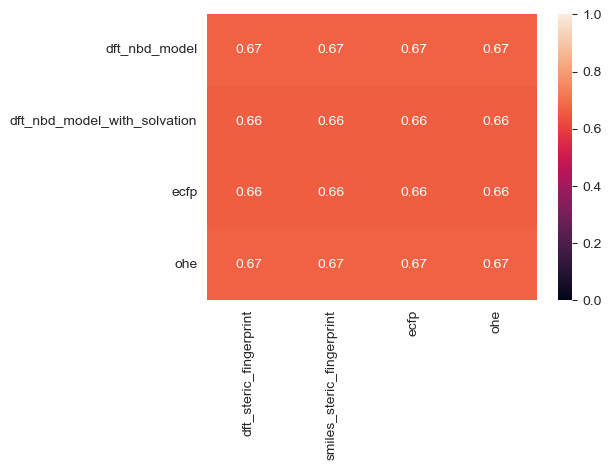

In [61]:
# plot heatmap for all ligand/substrate representations and save heatmap figure + csv in folder
fig = sns.heatmap(res_df, annot=True, vmin=0, vmax=1)
prefix_list = ['train'] + list_of_training_substrates + ['predict'] + list_of_test_substrates
prefix = '_'.join(prefix_list)
threshold_str = str(target_threshold).replace('.', '')
filename = f'{prefix}_heatmap_per_rep_classification_{target}_threshold_{threshold_str}'
plt.tight_layout()
fig.figure.savefig(os.path.join(path_to_figure_folder, filename + '.png'), dpi=300)
res_df.to_csv(os.path.join(path_to_figure_folder, filename + '.csv'), index=False)

In [34]:
# %%capture training_test_performance_plots
# # plot test performance during training
# for i, name in enumerate(AVAILABLE_LIGAND_REPRESENTATION_TYPES):
#     fig, ax = plt.subplots()
#     ax.set_title(f'Training performance for ligand {name}')
#     ax.set_xticks(range(len(AVAILABLE_SUBSTRATE_REPRESENTATION_TYPES)))
#     ax.set_xticklabels(AVAILABLE_SUBSTRATE_REPRESENTATION_TYPES, rotation=90)
#     # set y range between 0 and 1
#     ax.set_ylim([0, 1])
#     ax.set_ylabel('Balanced accuracy')
#     plt.errorbar(range(len(AVAILABLE_SUBSTRATE_REPRESENTATION_TYPES)), list_of_test_scores_mean[i], yerr=list_of_test_scores_std[i], fmt='.k')
#     plt.show()

ValueError: 'x' and 'y' must have the same size

In [ ]:
# plots are stored in capture object and can be shown by running this cell
# training_test_performance_plots()